# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Keeps values as float with max 3 decimal places
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Read and PreProcess Data

In [2]:
### http://data.un.org/Explorer.aspx

def process_un_energy_csv(df):
    if df["Unit"][0] == "Terajoules": # 1 Terajoule = 277778 Million kwh
        df["Quantity"] = 277778*df["Quantity"]/1000000
        df["Unit"] = "Kilowatt-hours, million"
    df = df.drop("Quantity Footnotes", axis=1) # Removes Footnote column
    df = df.drop("Commodity - Transaction", axis=1)
    df = df[:len(df)-2] # Removes last 2 extra rows
    df["Year"] = df["Year"].astype(int)
    return df

# Process Hydro Energy Production Data
hydro_df = pd.read_csv("hydro_prod.csv")
hydro_df = process_un_energy_csv(hydro_df)

# Process Solar Energy Production Data
solar_df = pd.read_csv("solar_prod.csv")
solar_df = process_un_energy_csv(solar_df)

# Process Wind Energy Production Data
wind_df = pd.read_csv("wind_prod.csv")
wind_df = process_un_energy_csv(wind_df)

# Process Nuclear Energy Production Data
nuclear_df = pd.read_csv("nuclear_prod.csv")
nuclear_df = process_un_energy_csv(nuclear_df)

# Natural Gas Data
ng_df = pd.read_csv("nat_gas.csv")
ng_df = process_un_energy_csv(ng_df)

# Read and process gdp data
gdp_usd = pd.read_csv("gdp.csv")
gdp_usd = gdp_usd[gdp_usd["Item"] == "Gross Domestic Product (GDP)"]
gdp_usd = gdp_usd.drop("Item", axis=1)

# Combine Data (NaN Possible)

In [3]:
# Combine hydro and solar to 1 df
prod_df = pd.merge(hydro_df, solar_df, how="outer", on=["Country or Area", "Year", "Unit"])
prod_df.rename(columns={"Quantity_x": "Hydro", "Quantity_y": "Solar"}, inplace=True)

# Add wind data to prod_df
prod_df = pd.merge(prod_df, wind_df, how="outer", on=["Country or Area", "Year", "Unit"])
prod_df.rename(columns={"Quantity": "Wind"}, inplace=True)

# Add nuclear data to prod_df
prod_df = pd.merge(prod_df, nuclear_df, how="outer", on=["Country or Area", "Year", "Unit"])
prod_df.rename(columns={"Quantity": "Nuclear"}, inplace=True)

# Add natural gas data to prod_df
prod_df = pd.merge(prod_df, ng_df, how="outer", on=["Country or Area", "Year", "Unit"])
prod_df.rename(columns={"Quantity": "Natural Gas"}, inplace=True)

# Add gdp data to prod_df
prod_df = pd.merge(prod_df, gdp_usd, how="outer", on=["Country or Area", "Year"])
prod_df.rename(columns={"Value": "GDP"}, inplace=True)

prod_df.dropna(subset=["Unit"], inplace=True)
prod_df = prod_df[prod_df["Year"] < 2021]

prod_df["Info Category"] = "Energy Production"
prod_df

,Country or Area,Year,Unit,Hydro,Solar,Wind,Nuclear,Natural Gas,GDP,Info Category
1,Afghanistan,2020,"Kilowatt-hours, million",1180.670,31.930,nan,nan,869.302,20143441791.662,Energy Production
2,Afghanistan,2019,"Kilowatt-hours, million",1388.040,20.770,nan,nan,1395.002,18904490263.110,Energy Production
3,Afghanistan,2018,"Kilowatt-hours, million",1065.790,nan,nan,nan,1660.562,18418848299.942,Energy Production
4,Afghanistan,2017,"Kilowatt-hours, million",1243.780,nan,nan,nan,1691.995,18896352021.476,Energy Production
5,Afghanistan,2016,"Kilowatt-hours, million",1239.200,nan,nan,nan,1791.716,18019558182.217,Energy Production
...,...,...,...,...,...,...,...,...,...,...
5843,United Arab Emirates,1992,"Kilowatt-hours, million",nan,nan,nan,nan,315740.530,54948005423.046,Energy Production
5844,United Arab Emirates,1991,"Kilowatt-hours, million",nan,nan,nan,nan,322851.369,52225758567.148,Energy Production
5845,United Arab Emirates,1990,"Kilowatt-hours, million",nan,nan,nan,nan,290950.788,51363957467.448,Energy Production
5848,Yemen,2010,"Kilowatt-hours, million",nan,nan,nan,nan,72143.113,30906751818.216,Energy Production


# Descriptive Statistics Before Removing NaN

In [4]:
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5700 entries, 1 to 5849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country or Area  5700 non-null   object 
 1   Year             5700 non-null   int64  
 2   Unit             5700 non-null   object 
 3   Hydro            4790 non-null   float64
 4   Solar            2450 non-null   float64
 5   Wind             2196 non-null   float64
 6   Nuclear          943 non-null    float64
 7   Natural Gas      2892 non-null   float64
 8   GDP              4920 non-null   float64
 9   Info Category    5700 non-null   object 
dtypes: float64(6), int64(1), object(3)
memory usage: 489.8+ KB


In [5]:
prod_df.describe()

,Year,Hydro,Solar,Wind,Nuclear,Natural Gas,GDP
count,5700.000,4790.000,2450.000,2196.000,943.000,2892.000,4920.000
mean,2006.054,20522.748,1504.487,5048.301,83316.900,398199.193,269737210798.237
std,8.879,74240.584,10299.062,25881.433,155282.806,1149679.842,1212444182248.787
min,1990.000,0.000,0.000,0.000,0.000,0.000,13278694.867
25%,1999.000,231.200,1.305,5.170,10762.000,2874.030,5015489669.474
50%,2007.000,2368.971,8.000,79.350,23580.000,53538.971,19568206077.865
75%,2014.000,10200.000,91.075,1059.457,76784.000,320446.715,117023758346.696
max,2020.000,1355210.000,260857.000,466470.000,843330.055,12372097.621,21380976000000.000


# Replace NaN Values with 0

In [6]:
prod_df.fillna(0, inplace=True)
prod_df

,Country or Area,Year,Unit,Hydro,Solar,Wind,Nuclear,Natural Gas,GDP,Info Category
1,Afghanistan,2020,"Kilowatt-hours, million",1180.670,31.930,0.000,0.000,869.302,20143441791.662,Energy Production
2,Afghanistan,2019,"Kilowatt-hours, million",1388.040,20.770,0.000,0.000,1395.002,18904490263.110,Energy Production
3,Afghanistan,2018,"Kilowatt-hours, million",1065.790,0.000,0.000,0.000,1660.562,18418848299.942,Energy Production
4,Afghanistan,2017,"Kilowatt-hours, million",1243.780,0.000,0.000,0.000,1691.995,18896352021.476,Energy Production
5,Afghanistan,2016,"Kilowatt-hours, million",1239.200,0.000,0.000,0.000,1791.716,18019558182.217,Energy Production
...,...,...,...,...,...,...,...,...,...,...
5843,United Arab Emirates,1992,"Kilowatt-hours, million",0.000,0.000,0.000,0.000,315740.530,54948005423.046,Energy Production
5844,United Arab Emirates,1991,"Kilowatt-hours, million",0.000,0.000,0.000,0.000,322851.369,52225758567.148,Energy Production
5845,United Arab Emirates,1990,"Kilowatt-hours, million",0.000,0.000,0.000,0.000,290950.788,51363957467.448,Energy Production
5848,Yemen,2010,"Kilowatt-hours, million",0.000,0.000,0.000,0.000,72143.113,30906751818.216,Energy Production


# Descriptive Statistics After Removing NaN

In [7]:
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5700 entries, 1 to 5849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country or Area  5700 non-null   object 
 1   Year             5700 non-null   int64  
 2   Unit             5700 non-null   object 
 3   Hydro            5700 non-null   float64
 4   Solar            5700 non-null   float64
 5   Wind             5700 non-null   float64
 6   Nuclear          5700 non-null   float64
 7   Natural Gas      5700 non-null   float64
 8   GDP              5700 non-null   float64
 9   Info Category    5700 non-null   object 
dtypes: float64(6), int64(1), object(3)
memory usage: 489.8+ KB


In [8]:
prod_df.describe()

,Year,Hydro,Solar,Wind,Nuclear,Natural Gas,GDP
count,5700.000,5700.000,5700.000,5700.000,5700.000,5700.000,5700.000
mean,2006.054,17246.309,646.665,1944.924,13783.831,202033.696,232825803004.794
std,8.879,68469.657,6792.348,16249.080,70315.352,842701.561,1130230188760.125
min,1990.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1999.000,45.968,0.000,0.000,0.000,0.000,2133523057.864
50%,2007.000,1181.950,0.000,0.000,0.000,2.222,13072923808.539
75%,2014.000,7729.043,4.540,13.686,0.000,56873.499,82075892470.012
max,2020.000,1355210.000,260857.000,466470.000,843330.055,12372097.621,21380976000000.000


# Plot Random Country's Energy

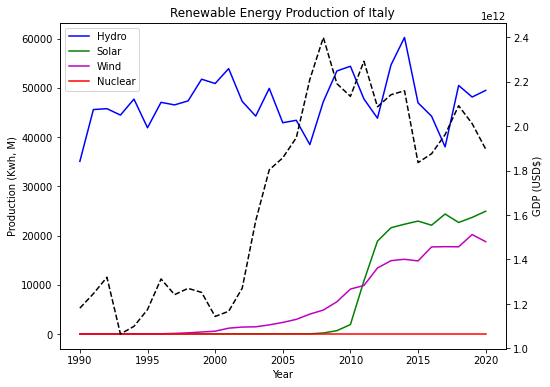

In [9]:
num = random.sample(range(0, len(prod_df)), 1)
country = prod_df.iloc[num, 0].tolist()[0]

country = "Italy"
country_df = prod_df[prod_df["Country or Area"] == country].sort_values("Year")

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(country_df["Year"], country_df["Hydro"], label="Hydro", color="blue")
ax.plot(country_df["Year"], country_df["Solar"], label="Solar", color="green")
ax.plot(country_df["Year"], country_df["Wind"], label="Wind", color="m")
ax.plot(country_df["Year"], country_df["Nuclear"], label="Nuclear", color="red")
# ax.plot(country_df["Year"], country_df["Natural Gas"], label="Natural Gas", color="pink")

ax2 = ax.twinx()
ax2.plot(country_df["Year"], country_df["GDP"], color="black", linestyle="--")

plt.title("Renewable Energy Production of {}".format(country))
ax.set_xlabel("Year")
ax.set_ylabel("Production (Kwh, M)")
ax2.set_ylabel("GDP (USD$)")
ax.legend()
plt.show()

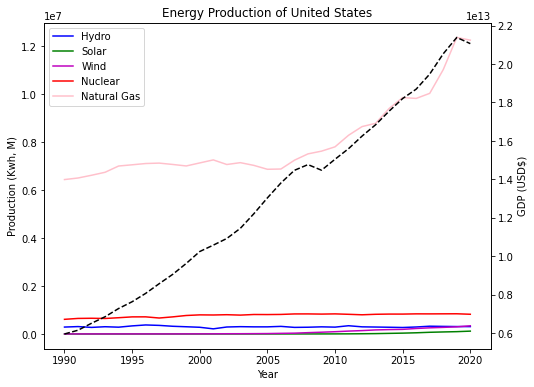

In [10]:
country = "United States"
country_df = prod_df[prod_df["Country or Area"] == country].sort_values("Year")

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(country_df["Year"], country_df["Hydro"], label="Hydro", color="blue")
ax.plot(country_df["Year"], country_df["Solar"], label="Solar", color="green")
ax.plot(country_df["Year"], country_df["Wind"], label="Wind", color="m")
ax.plot(country_df["Year"], country_df["Nuclear"], label="Nuclear", color="red")
ax.plot(country_df["Year"], country_df["Natural Gas"], label="Natural Gas", color="pink")

ax2 = ax.twinx()
ax2.plot(country_df["Year"], country_df["GDP"], color="black", linestyle="--")

plt.title("Energy Production of {}".format(country))
ax.set_xlabel("Year")
ax.set_ylabel("Production (Kwh, M)")
ax2.set_ylabel("GDP (USD$)")
ax.legend()
plt.show()

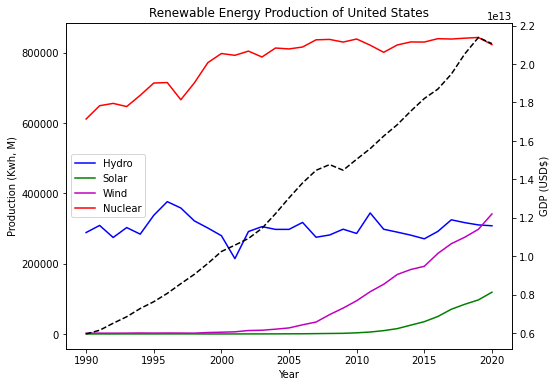

In [11]:
country = "United States"
country_df = prod_df[prod_df["Country or Area"] == country].sort_values("Year")

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(country_df["Year"], country_df["Hydro"], label="Hydro", color="blue")
ax.plot(country_df["Year"], country_df["Solar"], label="Solar", color="green")
ax.plot(country_df["Year"], country_df["Wind"], label="Wind", color="m")
ax.plot(country_df["Year"], country_df["Nuclear"], label="Nuclear", color="red")

ax2 = ax.twinx()
ax2.plot(country_df["Year"], country_df["GDP"], color="black", linestyle="--")

plt.title("Renewable Energy Production of {}".format(country))
ax.set_xlabel("Year")
ax.set_ylabel("Production (Kwh, M)")
ax2.set_ylabel("GDP (USD$)")
ax.legend()
plt.show()

In [12]:
prod_df.to_csv("prod_data.csv")
ng_df.to_csv("nat_gas_same_units.csv")

# Ratio of Natural Gas to Renewable for top 10 GDPs

In [13]:
ratio_1990 = prod_df[prod_df["Year"] == 1990]
ratio_1990 = ratio_1990.sort_values("GDP", ascending=False).head(10).sort_values("Country or Area")
ratio_1990["renewable"] = ratio_1990["Hydro"]+ratio_1990["Solar"]+ratio_1990["Wind"]+ratio_1990["Nuclear"]
ratio_1990["ratio"] = ratio_1990["renewable"] / ratio_1990["Natural Gas"]
ratio_1990

,Country or Area,Year,Unit,Hydro,Solar,Wind,Nuclear,Natural Gas,GDP,Info Category,renewable,ratio
249,Australia,1990,"Kilowatt-hours, million",14880.000,0.000,0.000,0.000,246062.629,324216727337.067,Energy Production,14880.000,0.060
568,Brazil,1990,"Kilowatt-hours, million",206708.000,0.000,0.000,2237.000,76290.894,408823128267.670,Energy Production,208945.000,2.739
757,Canada,1990,"Kilowatt-hours, million",296848.000,0.000,0.000,72967.000,1383557.496,596088363223.415,Energy Production,369815.000,0.267
1544,France,1990,"Kilowatt-hours, million",57418.000,0.000,0.000,314081.000,34075.027,1269138608283.330,Energy Production,371499.000,10.902
2025,India,1990,"Kilowatt-hours, million",71656.000,0.000,32.000,6141.000,195083.478,329139432438.827,Energy Production,77829.000,0.399
2229,Italy,1990,"Kilowatt-hours, million",35079.000,4.000,2.000,0.000,181295.701,1181283986443.050,Energy Production,35085.000,0.194
2292,Japan,1990,"Kilowatt-hours, million",97033.000,67.000,0.000,202272.000,24778.631,3132817652848.040,Energy Production,299372.000,12.082
3156,Netherlands,1990,"Kilowatt-hours, million",85.000,0.000,56.000,3502.000,709832.512,318327698511.176,Energy Production,3643.000,0.005
4056,Spain,1990,"Kilowatt-hours, million",26184.000,9.000,14.000,54268.000,17614.736,536527782597.573,Energy Production,80475.000,4.569
4624,United States,1990,"Kilowatt-hours, million",288960.000,666.000,3066.000,611589.000,6443155.988,5963144000000.000,Energy Production,904281.000,0.140


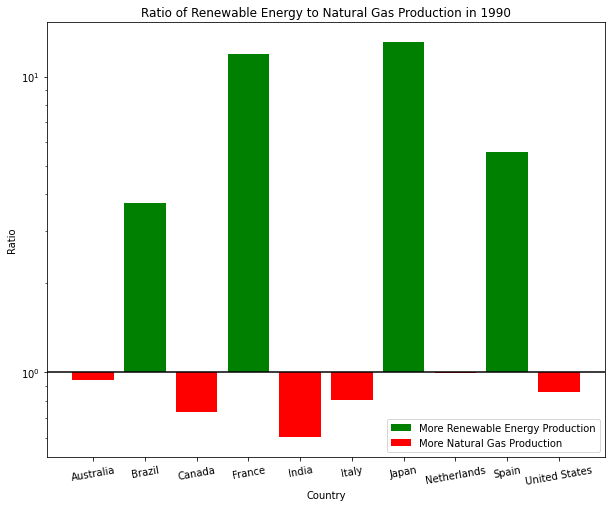

In [14]:
pos = []
neg = []
for i in ratio_1990["ratio"]:
    if i >= 1:
        pos.append(i)
        neg.append(0)
    else:
        pos.append(0)
        neg.append(-1*i)

fig, ax = plt.subplots(figsize=(10,8))

ax.bar(ratio_1990["Country or Area"], pos, label="More Renewable Energy Production", color="green", bottom=1)
ax.bar(ratio_1990["Country or Area"], neg, label="More Natural Gas Production", color="red", bottom=1)

ax.set_yscale('log')
plt.axhline(y = 1, color = 'black', linestyle = '-')
plt.title("Ratio of Renewable Energy to Natural Gas Production in 1990")
plt.xlabel("Country")
plt.ylabel("Ratio")
plt.xticks(rotation = 10)
plt.legend(loc="lower right")
plt.show()

In [15]:
ratio_1990 = prod_df[prod_df["Year"] == 1990]
ratio_1990 = ratio_1990.sort_values("GDP", ascending=False).head(10)
countries = ratio_1990["Country or Area"]

ratio_2020 = prod_df[prod_df["Year"] == 2020]
ratio_2020 = ratio_2020[ratio_2020["Country or Area"].isin(countries)].sort_values("Country or Area")
ratio_2020["renewable"] = ratio_2020["Hydro"]+ratio_2020["Solar"]+ratio_2020["Wind"]+ratio_2020["Nuclear"]
ratio_2020["ratio"] = ratio_2020["renewable"] / ratio_2020["Natural Gas"]
ratio_2020

,Country or Area,Year,Unit,Hydro,Solar,Wind,Nuclear,Natural Gas,GDP,Info Category,renewable,ratio
219,Australia,2020,"Kilowatt-hours, million",15149.633,21033.194,20395.885,0.000,1682047.411,1431725487761.040,Energy Production,56578.712,0.034
538,Brazil,2020,"Kilowatt-hours, million",396328.000,10750.000,57050.000,14053.000,566676.287,1448565667225.450,Energy Production,478181.000,0.844
727,Canada,2020,"Kilowatt-hours, million",386617.000,4846.000,35638.000,98195.000,2309215.181,1645423407568.360,Energy Production,525296.000,0.227
1514,France,2020,"Kilowatt-hours, million",66532.417,13398.392,39791.901,353832.867,201.243,2639008701648.260,Energy Production,473555.577,2353.154
1995,India,2020,"Kilowatt-hours, million",160909.000,61291.000,67418.000,43029.000,309626.914,2672203719262.290,Energy Production,332647.000,1.074
2199,Italy,2020,"Kilowatt-hours, million",49495.255,24941.504,18761.557,0.000,42478.295,1896755301518.140,Energy Production,93198.316,2.194
2262,Japan,2020,"Kilowatt-hours, million",87548.296,79086.858,8969.849,38751.685,25091.273,5040107754084.110,Energy Production,214356.688,8.543
3126,Netherlands,2020,"Kilowatt-hours, million",46.066,8765.172,15339.130,4087.363,223239.677,909793466661.481,Energy Production,28237.731,0.126
4026,Spain,2020,"Kilowatt-hours, million",33998.000,20667.000,56444.000,58299.000,538.756,1276962685648.250,Energy Production,169408.000,314.443
4594,United States,2020,"Kilowatt-hours, million",308212.917,119328.543,341818.283,823149.528,12260402.353,21060474000000.000,Energy Production,1592509.271,0.130


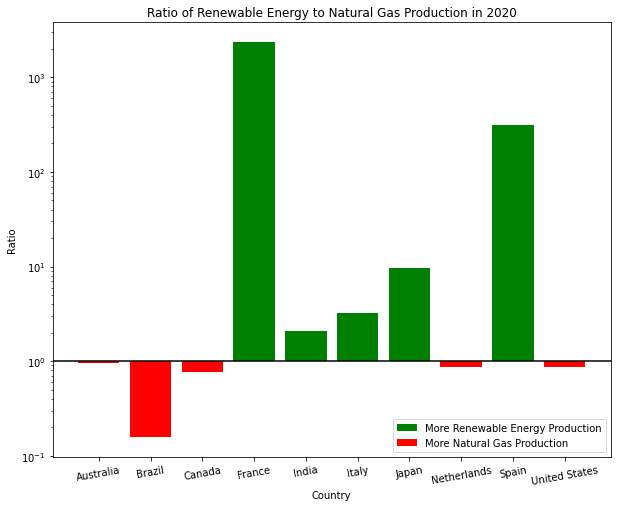

In [16]:
pos = []
neg = []
for i in ratio_2020["ratio"]:
    if i >= 1:
        pos.append(i)
        neg.append(0)
    else:
        pos.append(0)
        neg.append(-1*i)

fig, ax = plt.subplots(figsize=(10,8))

ax.bar(ratio_2020["Country or Area"], pos, label="More Renewable Energy Production", color="green", bottom=1)
ax.bar(ratio_2020["Country or Area"], neg, label="More Natural Gas Production", color="red", bottom=1)

ax.set_yscale('log')
plt.axhline(y = 1, color = 'black', linestyle = '-')
plt.title("Ratio of Renewable Energy to Natural Gas Production in 2020")
plt.xlabel("Country")
plt.ylabel("Ratio")
plt.xticks(rotation = 10)
plt.legend(loc="lower right")
plt.show()